Resource Citation:
https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning

(Code Examples & Notes Have Been Retrieved From This Source)

Quantum Machine Learning (QML)

It refers to the application of quantum computing to any machine learning process. Both spervised and unsupervised learning algorithsm involve the embedding of data in higher dimensional spaces.

In a classical setting if we have 4 bits then there are 2^4 or 16 possible states, wheras in a quantum setting these 16 states can exists in superposition to one another (with a total probability equal to 1).
These states in quantum computers are described by probability amplitude that can be complex numbers.

Gaussian feature maps when used in conjunction with the "kernel trick" sidestep the need to ever calculate an infinite dimensional mapped vector.
NOTE: High dimensionality of entangled quantum states is not exponential parallelism, and is not a sufficient condition for increased power in machine learning.

Dequantization refers to the replacement of a given quantum algorithm with a classical one that performs similarly to a quantum algorithm for a given set of tasks, typically including scaling.
Quantum speedup is characterized as a minimum of a quadratic speedup from its classical counterpart. One common approach to dequantization (though not the only trick) is through consideration of data loading overhead. That is, any quantum algorithm applied to classical data will have a step in which classical data are encoded into the quantum computer. If a quantum algorithm assumes a starting point at which quantum data are already available, then one effectively hides the time required for encoding.

Common Misconception: Most machine learning problems are solved very efficiently by classical algorithms and quantum algorithms are not likely to offer any substantial speed-up. The goal in QML is to finding datasets with features that are well-described by quantum states and/or to find mappings of data features that optimize the accuracy of models.

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.7 MB/s eta 0:00:00


In [2]:
# Example of mapping classical inputs to a quantum problem
# Optimizing the porblem for quantum execution
# Execute using Qiskit Runtime Primitives
# Analyzing / post-processing

In [3]:
# Import qiskit packages for setting up our quantum circuits
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import unitary_overlap

In [4]:
# Import StatevectorSamples
from qiskit.primitives import StatevectorSampler

**Map Classical Inputs to Quantum Problem**

In [5]:
# The data imported consists of 128 rows or data points
# 14 columns that correspond to data features and a 15th column with a label (+/- 1)
import pandas as pd
import numpy as np

!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

def get_training_data():
  df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
  # Select a subset (20 rows) to use as training data
  training_data = df.values[:20, :]
  # Sorts the training data based on the values in the last column - the label
  ind = np.argsort(training_data[:, -1])
  X_train = training_data[ind][:, :-1]
  return X_train


X_train = get_training_data()

# Empty Kernel Matrix
num_samples = np.shape(X_train)[0]

# Create a feature map for computiing the overlap between two data points

#Retrieves the number of features from you training data
num_features = np.shape(X_train)[1]

num_qubits = int(num_features / 2)

#Defines the list of pairs of qubits that will be entangles in the circuit.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)

fm.ry(training_param, fm.qubits)
#Applies controlled-Z (CZ) gates between the pairs of qubits specified
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

--2025-07-29 13:58:17--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49405 (48K) [text/plain]
Saving to: ‘dataset_graph7.csv’

dataset_graph7.csv  100%[===================>]  48.25K  --.-KB/s    in 0.008s  

2025-07-29 13:58:17 (6.15 MB/s) - ‘dataset_graph7.csv’ saved [49405/49405]



Execute the circuit using Qiskit Runtime Primitives

In [6]:
pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=4fc319ac1be171b778e98f48f45cd4ef925d112f1dcd1c85343eea92fce5488c
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


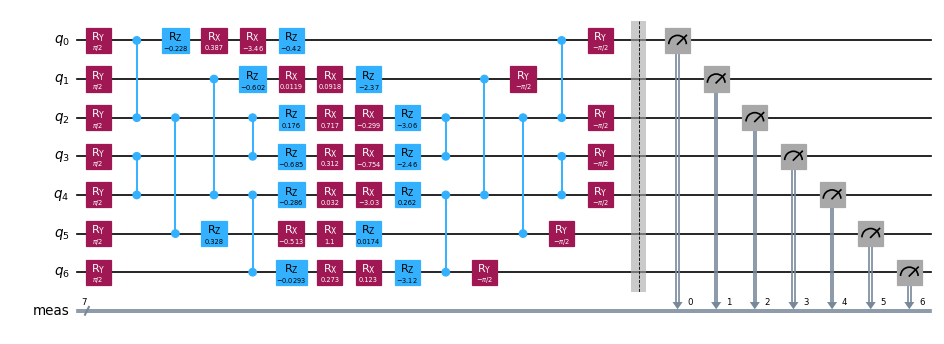

In [7]:
# Choose two data points and assign the features to the circuit as parameters
x1 = 14
x2 = 19
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

# Create the overlap circuit
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw("mpl", scale=0.6, style="iqp")

In [8]:
num_shots = 10_000

#This runs the overlap_circ on the StatevectorSampler for the specified number of shots
# .get_int_counts() method converts the measurement results into a dictionary-like object where the keys are the integer representations of the measured bitstrings and the values are the number of times each bitstring was measured.
sampler = StatevectorSampler()
counts = (
    sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
)

Analyze and Post-Processing

In [9]:
# Find the proability of 0
counts.get(0, 0.0) / num_shots

0.6947

Proability of measuring a various states are given by the inner product with an an intital state.  So what we have done above is created a quantum circuit that contains the features of our two data points, and maps them into the space of a quantum vector, then estimates the inner product in that space via making measurements. This is an example of quantum kernel estimation

Inner product: conjugate row vector of the output state multiplied with the intial state vector as a column

**Review of Relevant ML Methods **

Supervised Learning: The training data is labled, with the goal of these algorithms being to determine the relationship between the data and their corresponding labels or outputs (to generalize this to unseen data).
Unsupervised Learning: Uses unlabled data to train the machine learning model. Allows one to discover hidden patterns and structures in the data. Examples: generative models such as GANs and Variational Autoencoders.

Reinforcement Learning: Defined by an agent which interacts with an environment The agent takes actions and receives feedback from its environment in the form of rewards and punishments.

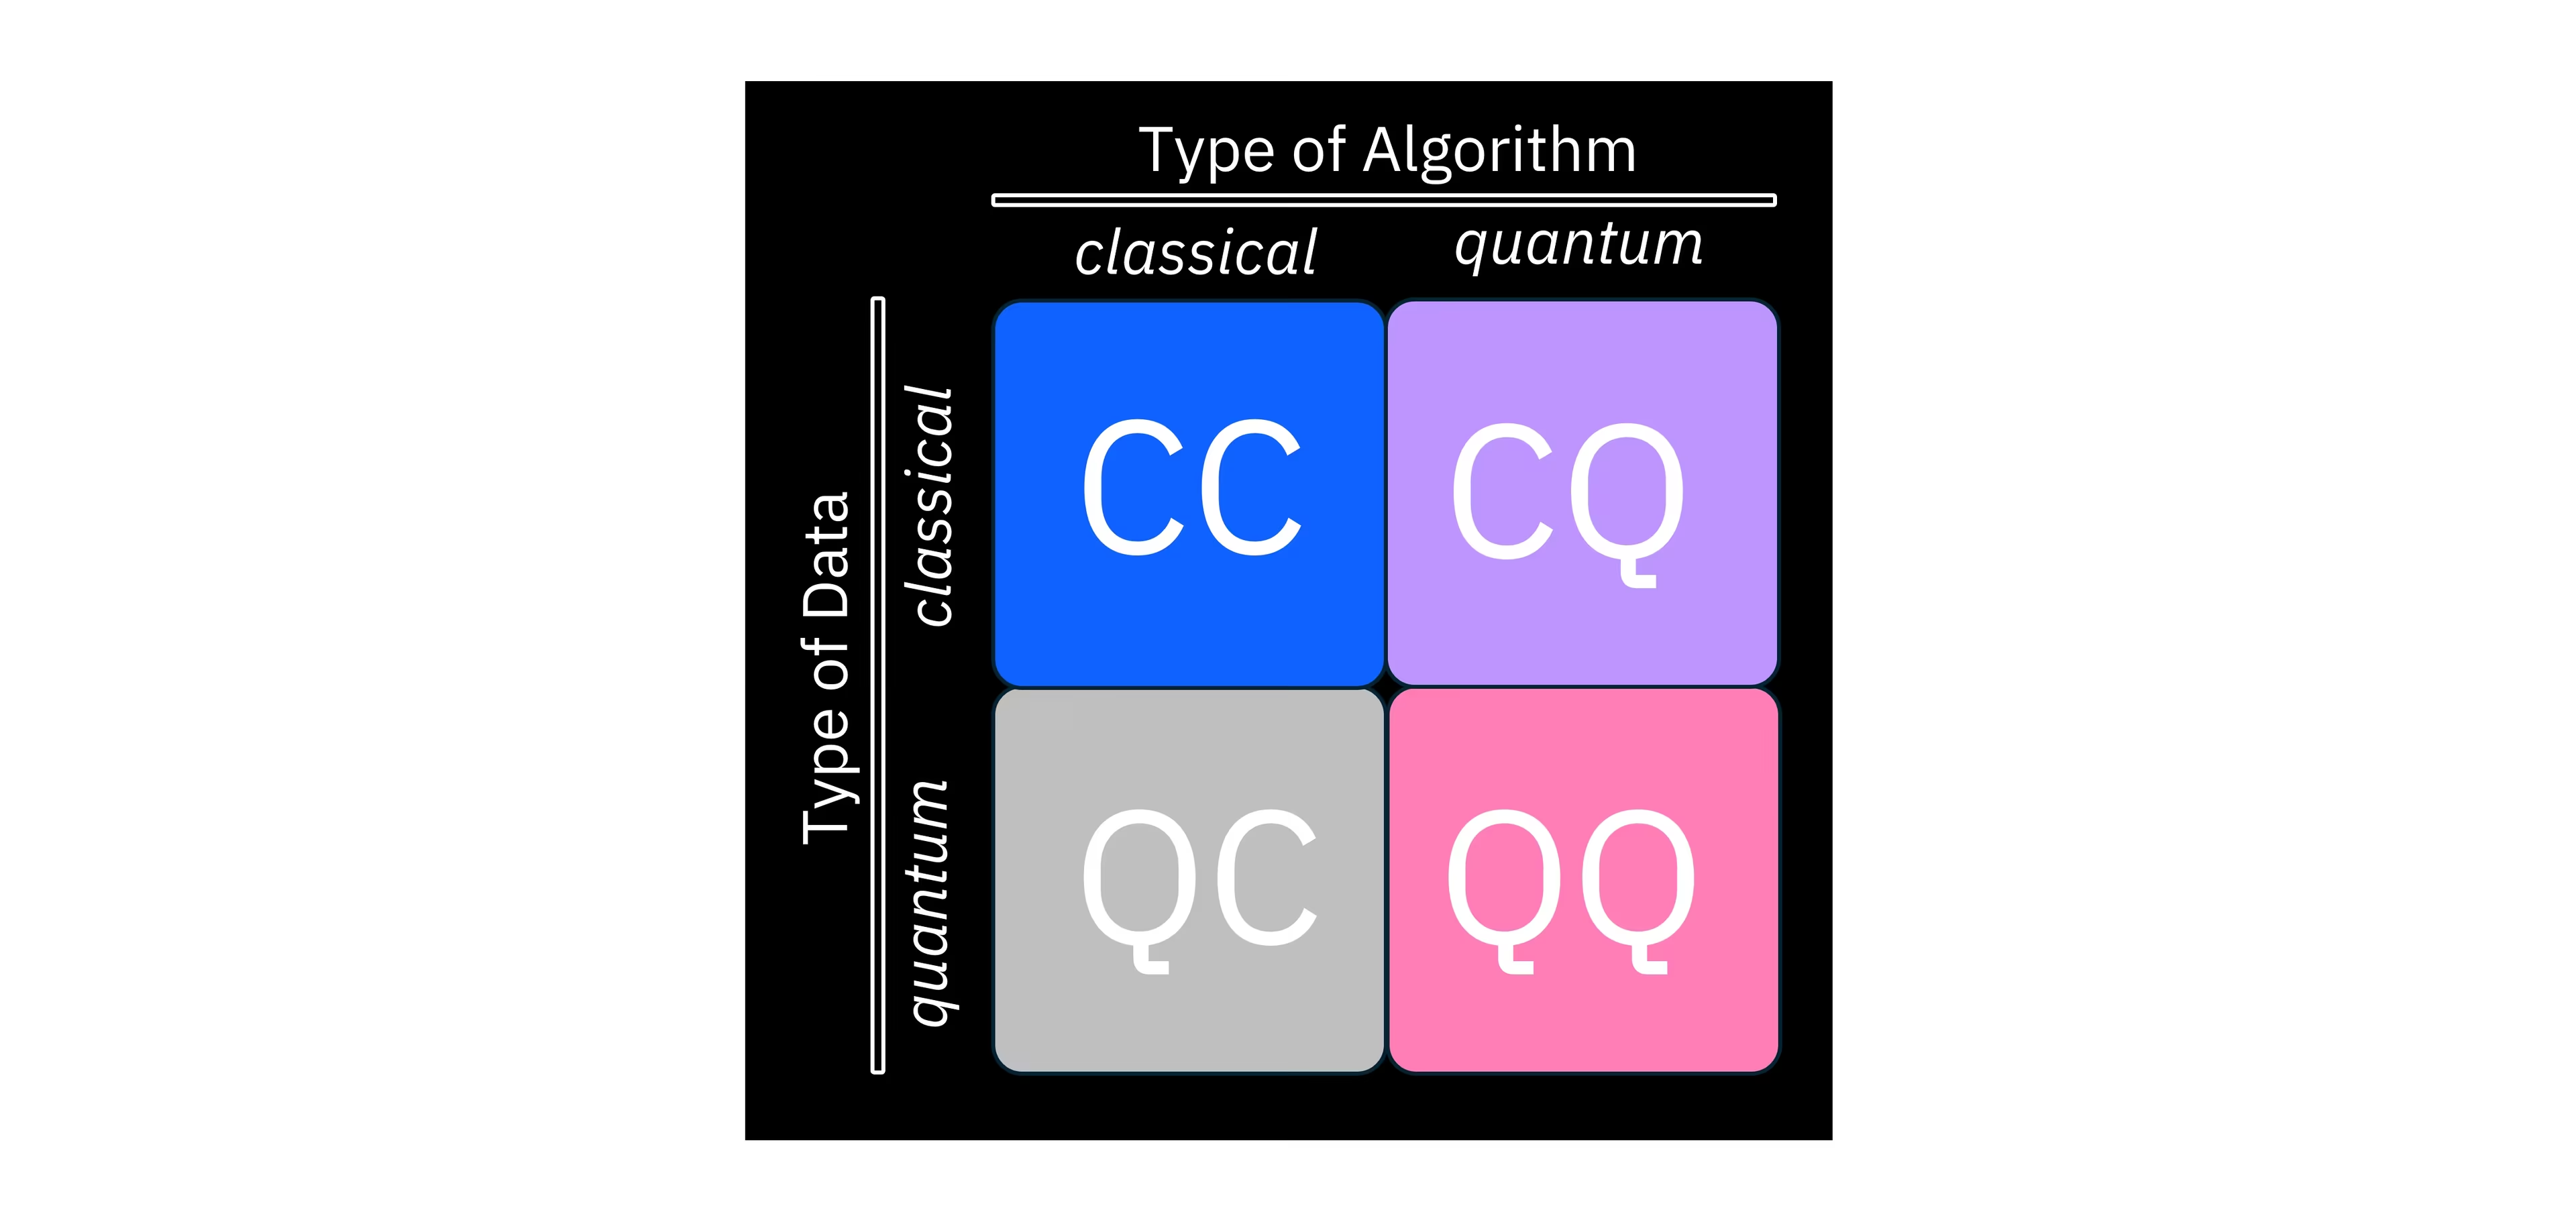

CC, for example, means that we have a classical dataset and use a classical computer to run a machine learning algorithm.
Quantum data could be thought of as a set of measurement outcomes obtained from a quantum device --> In the future, it could refer to data stored in QRAM (Quantum Random Access Memory).
When researchers talk about QML, they are usually referring to a CQ (Classical-Quantum) regime.

Support Vector Machines

Let's look at the task of binary classification on a dataset with a two-dimensional feature space. In general, there are infinitely many hyperplanes that separates the two classes: So how do we find the optimal one?

**A particularly good decision boundary should maximize the margin; the margin is defined as the distance to the nearest points in each class. In this setting, the data points with the smallest distance to the decision boundary are called the support vectors.**

The model is described as f1 and theta describes the set of parameters defining the hyperplane. x is the dataset, b is the constant shift, and phi is a mapping from the space of input data points (often) to a higher dimensional space.

Theta is the vector of tunable parameters that the model would learn --> this is called "primal foundation."

With some mathematical manipulation there is alternatively "dual formulation," depicted by f_2. For this formulation, we need to optimize over the alpha parameters.

The main difference is that in the primal formulation the equation has an inner product between the feature vector and the learnable parameters, whereas in the dual formulation the inner product is between feature vectors.

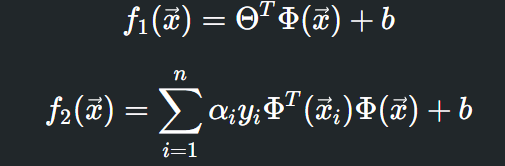

Kernel Methods and How Quantum Can Play a Role

Why is the inner/dot product so important?
It tells us about the orthogonality, or if the vectors are parallel/anti-parallel.
Not all data can be separated in an N-dimensional cut --> Mapping to higher dimensional numbers phi(x). Or from N --> M dimensional real numbers.
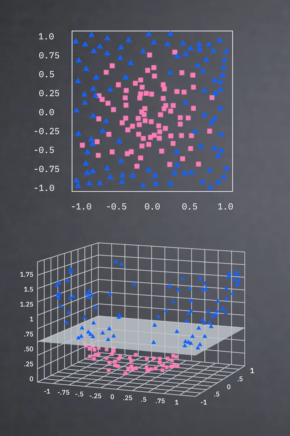

The figure above shows the embedding of 2D data into 3D spaces. We project onto higher dimensional spaces. We find a mapping from our data x to higher dimensional phi(x) such that the feature space is given by a simple function of the lower dimensional data - called k or a kernel function.

Notice the difference in the number of operations needed
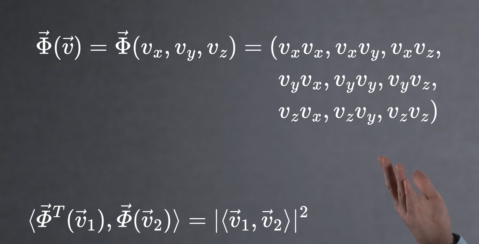

We use kernel function by taking pairs of data points from our set --> Taking pairs of data points results in a symmetric matrix called the kernel. The type of kernel you use depends on the type of problem.

'Feature Mapping" is denoted by Φ. This is computationally very beneficial because we can access the space in which data are linearly separable, but without the cost of manipulations in higher dimensions.

The kernel function itself is a function of two input data vectors. Inserting each pair of data vectors in the dataset as arguments of the kernel function results in a symmetric, positive semi-definite matrix, called the kernel matrix:

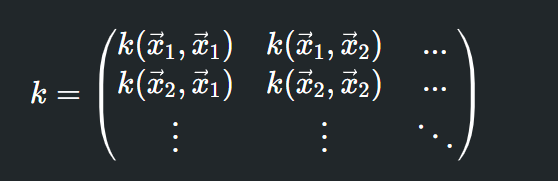

Once we compute the kernel matrix, then we can find the optimal parameters, using methods such as quadratic programming software or an algorithm called "sequenctial minimal optimization."

Recall that the inner product of two quantum states is related to the probability of measuring the state (initial state) when in a final state.

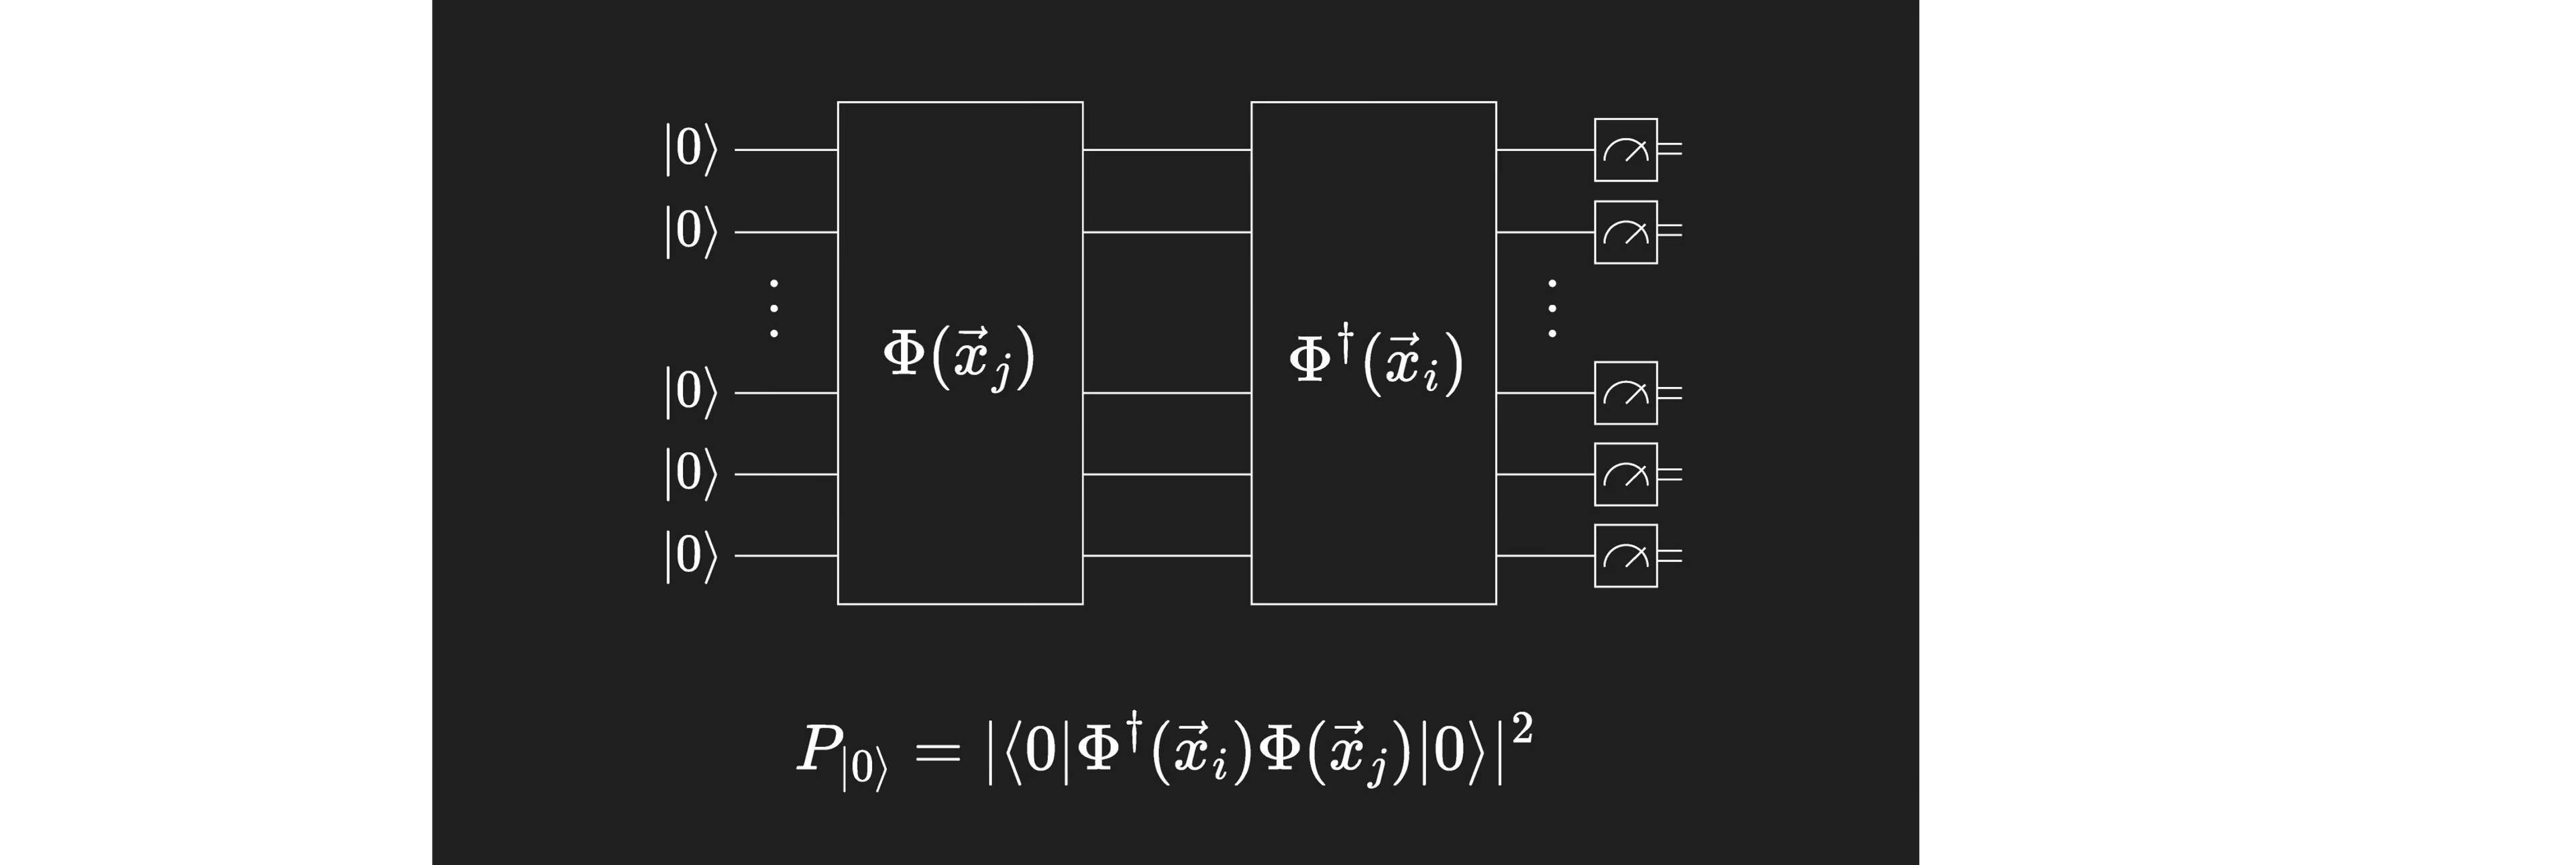

Variational Quantum Classifiers and Neural Networks

These often leverage structures similar to classical neural networks (NNs); and in those cases you will see them described as quantum neural networks (QNNs).

A neural network is a computational model which is loosely inspired by the structure and the function of neurons in a brain. These neurons, which are nodes that we see in the picture, are organized into layers, and are connected through weights.
Layer 1: Input Layer
Activations of neurons in this layer are fed in directly from the data x to be analyzed. If we focus on one of these neurons, we have the building block of a neural network, which is called a "perceptron".

A perceptron computes the dot inner product of an input vector with a trainable weight vector.

And very importantly, the perceptron applies a non-linear activation function (σ) on top of this computation. These non-linear activation functions are critical for the great expressive power of neural networks.

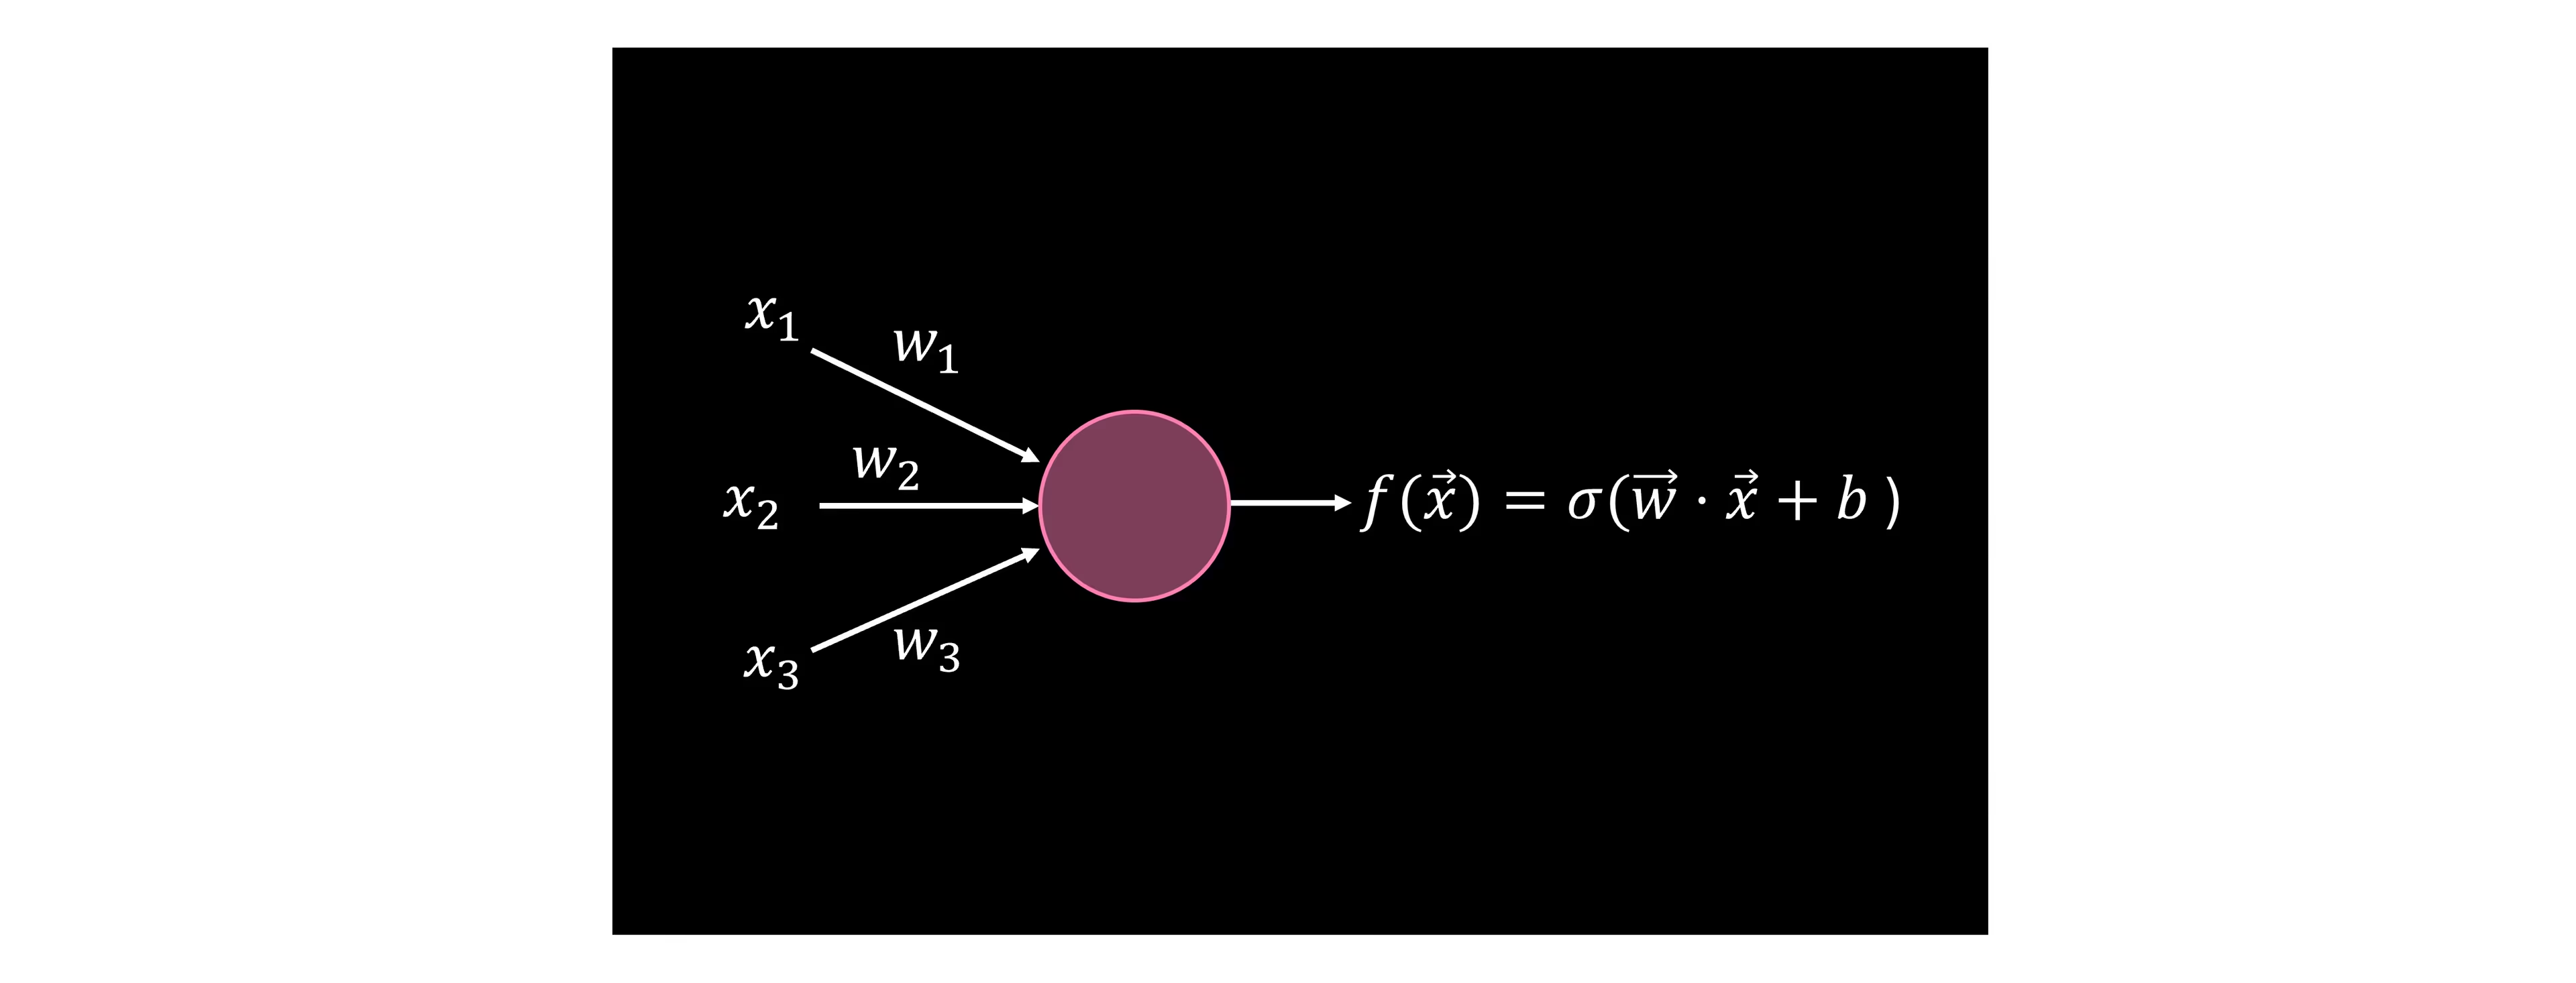

We then implement a cost function to describe how our nerual network deviates from correct classification. One example is mean-squared error (MSE).
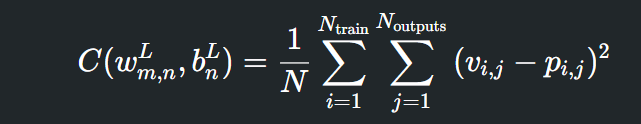

**Quantum Neural Network**


A QNN works by first encoding the input data with the unitary layer U in the figure, then applying quantum circuits corresponding to weights between layers, and finally a layer of measurement.

The data loading and weightings are linear operations.
The measurements are non-linear.
So as in the classical NN, we have both linear and non-linear components.
The weight circuits still have variational parameters, so there is still a classical minimization to be carried out.
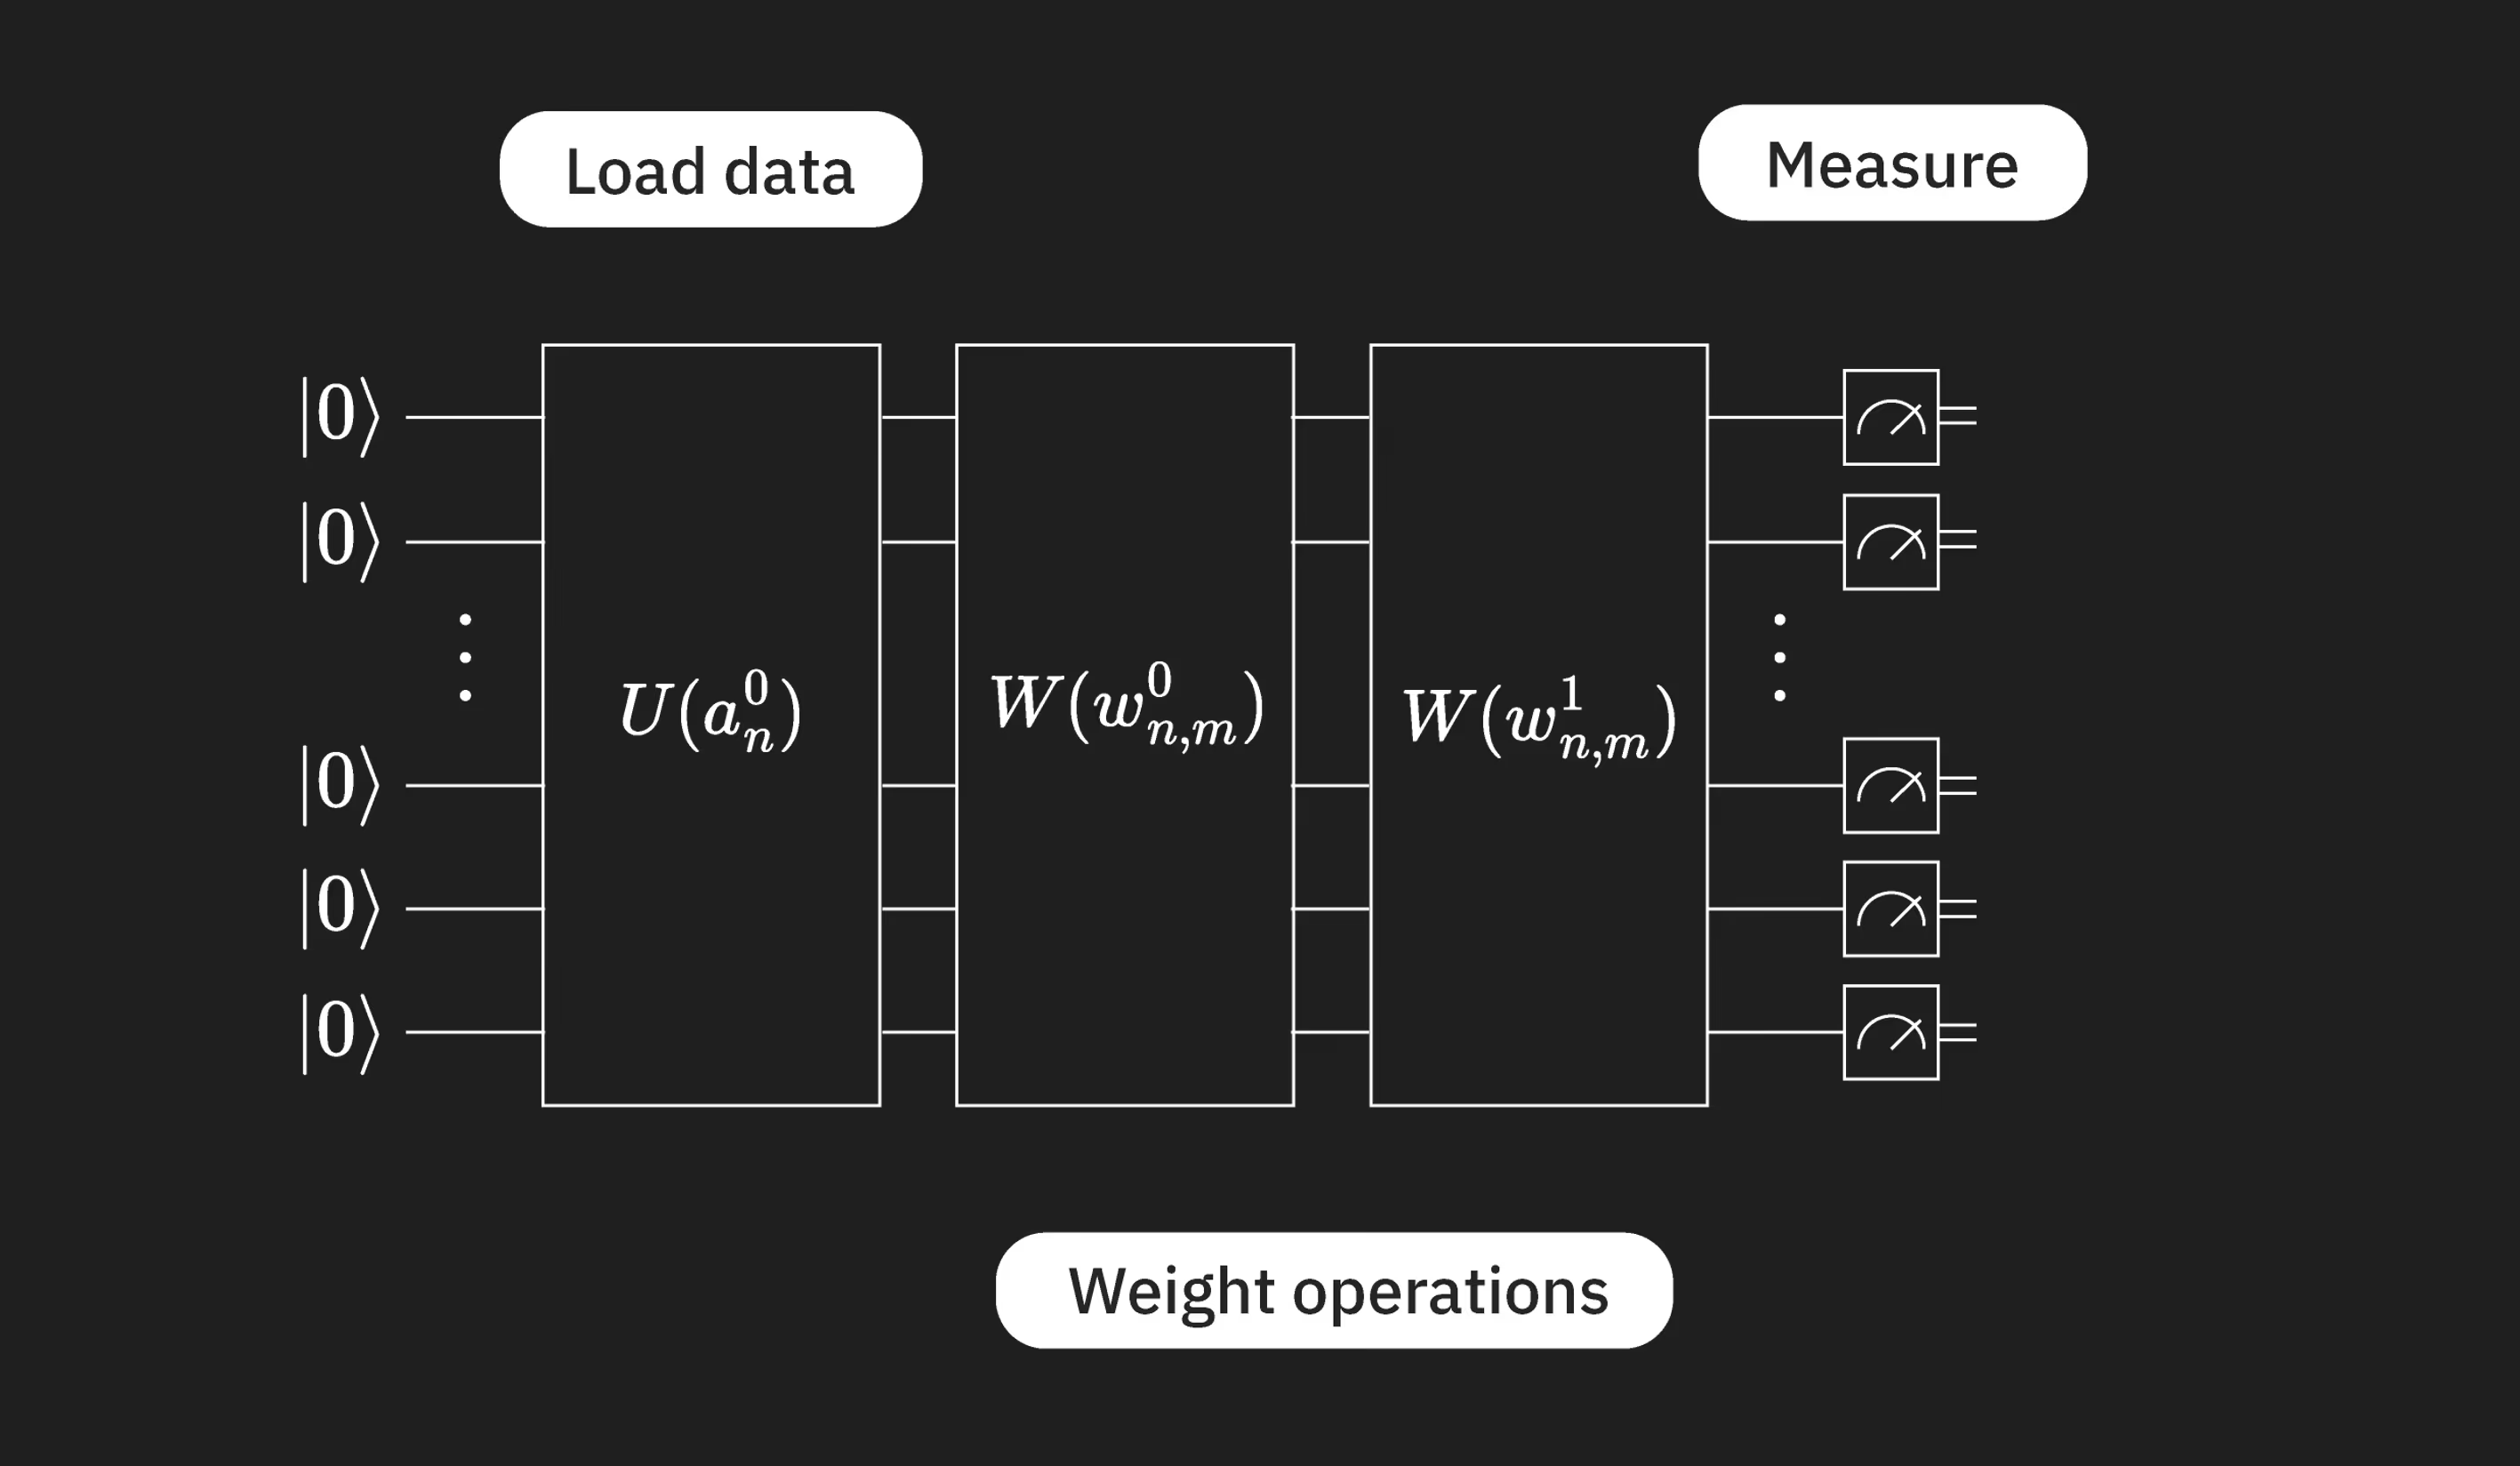

In the QNN below we see that the unitary block that encodes the data repeats itself between the variational unitary blocks with the trainable parameters.
This strategy, which we refer to as “data reuploading”, is backed by interesting theoretical results. With the help of multiple data-reuploading, “a single qubit provides sufficient computational capabilities to construct a universal quantum classifier when assisted with a classical subroutine.” Therefore, data reuploading is a technique that we can use to enhance the expressiveness and representational power of the model, allowing the quantum neural network to approximate complex functions.

Data Encoding
To use a quantum algorithm, classical data must somehow be brough into a quantum circuit --> this process is called data encoding or data loading.
The built-in feature mapping Qiskit (like z_Feature Map and ZZ Feature Map) will typically include rotation layers and entangling layer that extend the state to many dimensions in the Hilbert space.
This can sometime be directly translated to classical simulations easily in cases that yield product states (i.e. which do not entangle qubits).

Match encoding method and the quantum-like complexity of the dataset --> This means it is very likely you will end up writing your own encoding circuits.

Notation
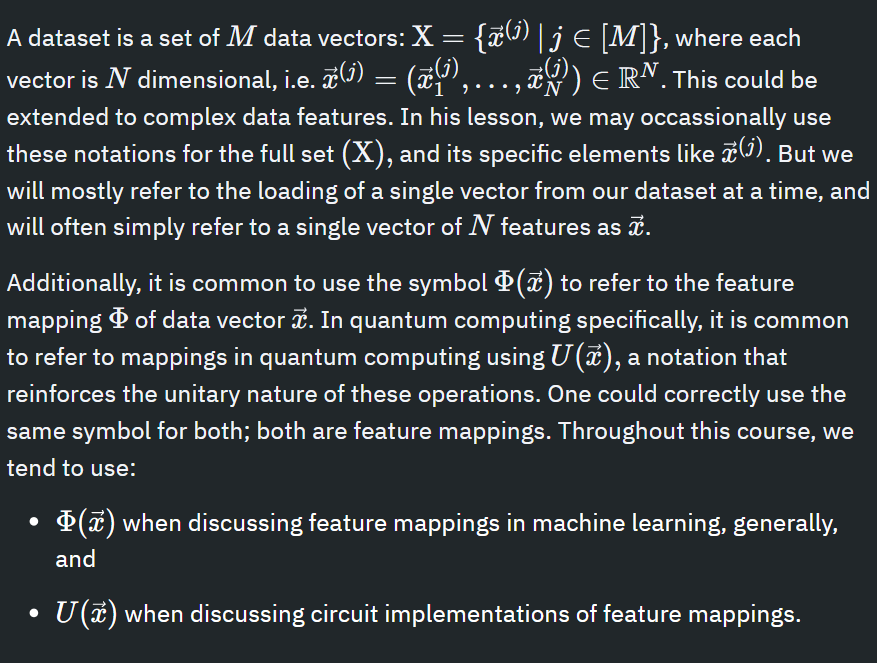

In classical ML training data features are often "normalized" or rescaled which often improves model performance (the scales of features may be very different such as 1-10 vs 10000 - 50000).

One common way of doing this is by using min-max normalization or standardization.

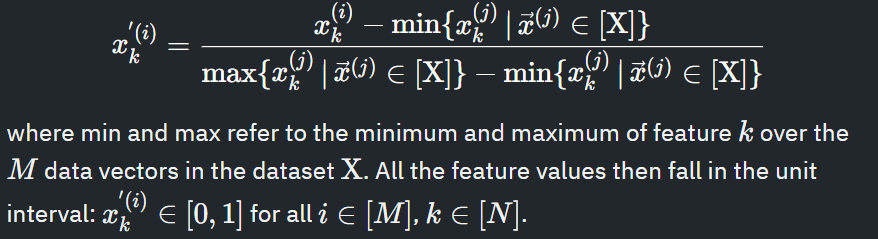

Make x_k ' have values in the unit interval.

Normalization in quantum mechanics requires that the length (the 2-norm) or a state vector is equal to the unit (magnitude or sqaure root of the inner product with itself).

In phase encoding, feature values are recommended to be rescaled as an element of (0, 2pi], so that there is not information loss due to the module-2pi effect of encoding to a qubit phase angle.

**Method of Encoding**

Basis Encoding
Encodes a classical P-bit string into a computational basis state of a P-qubit system. For example, x_3 ^ 1 (denotes the 3rd features of 1st vector) = 5 --> encoded as a 4-bit string (0101) and in the quantum state |0101>.
If each feature of this data vector is mapped to a quantum state, then we can describe a data vector from our set as a superposition of all the computational basis states describing the features of that vector:
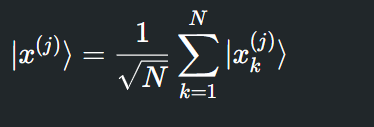

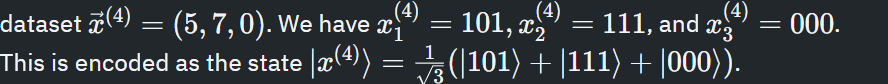

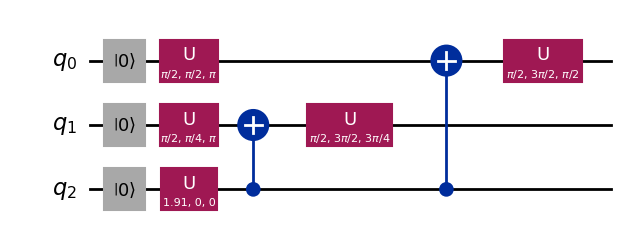

In [ ]:
import math
import numpy as np
from qiskit import QuantumCircuit

desired_state = [1 / math.sqrt(3), 0, 0, 0, 0, 1 / math.sqrt(3), 0, 1 / math.sqrt(3)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0, 1, 2])
qc.decompose(reps=8).draw(output="mpl")

# While this example is simpler to understand, the state vectors become quite sparse, and schemes to implement is are usually not efficient.

[0, 0, 0, 0, 0.5773502691896258, 0.5773502691896258, 0, 0, 0.5773502691896258, 0, 0, 0, 0, 0, 0, 0]


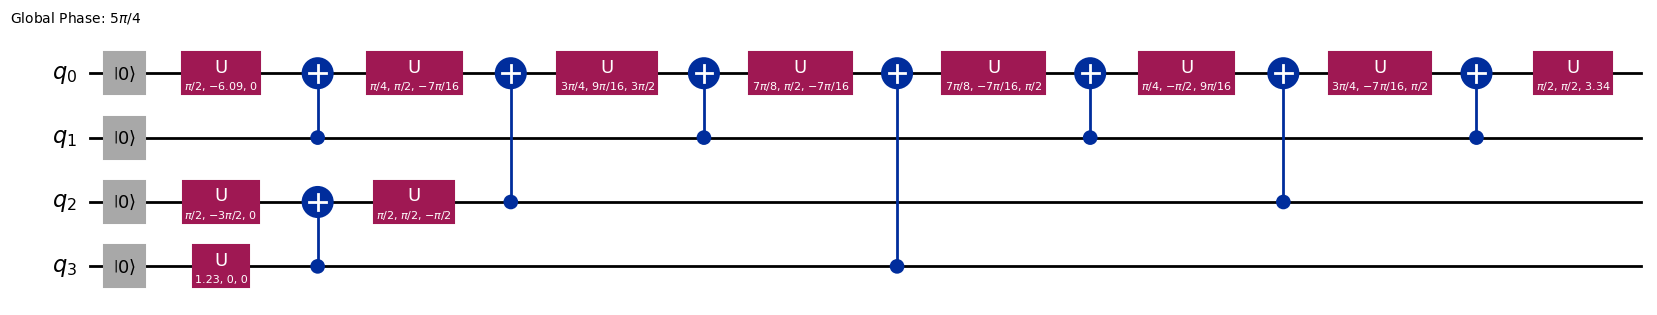

In [ ]:
#Another similar example for the basis encoding of the 1st vector in a dataset X = (4,8,5)
import math
from qiskit import QuantumCircuit

desired_state = [
    0,
    0,
    0,
    0,
    1 / math.sqrt(3),
    1 / math.sqrt(3),
    0,
    0,
    1 / math.sqrt(3),
    0,
    0,
    0,
    0,
    0,
    0,
    0,
]

print(desired_state)

qc = QuantumCircuit(4)
qc.initialize(desired_state, [0, 1, 2, 3])
qc.decompose(reps=7).draw(output="mpl")

**Amplitude Encoding**

Amplitude encoding encodes data into the amplitudes of a quantum state. Represents a normalized classical N-dimensional data vector, as the amplitudes of a n-qubit quantum state:
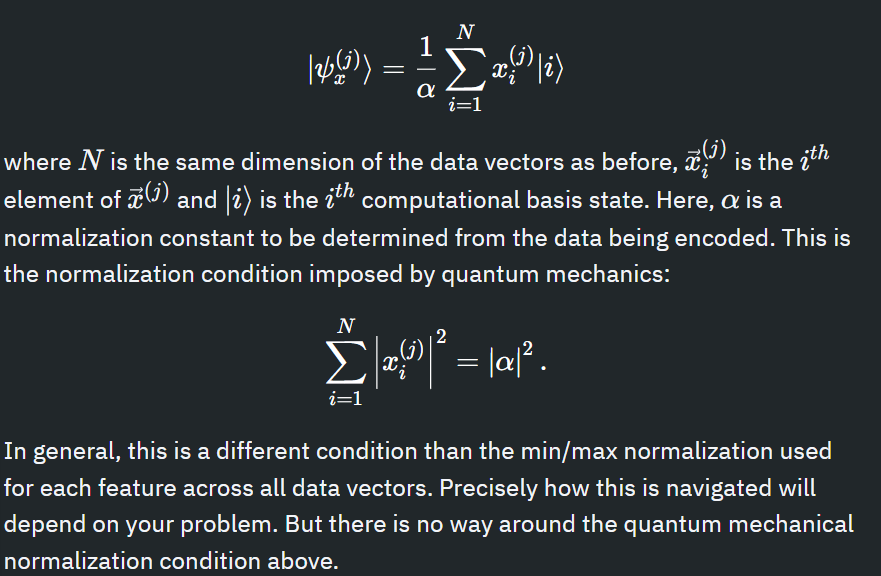

As a system of n qubits provides 2^n amplitudes, amplitude encoding of N features requires n >= log_2_(N) qubits

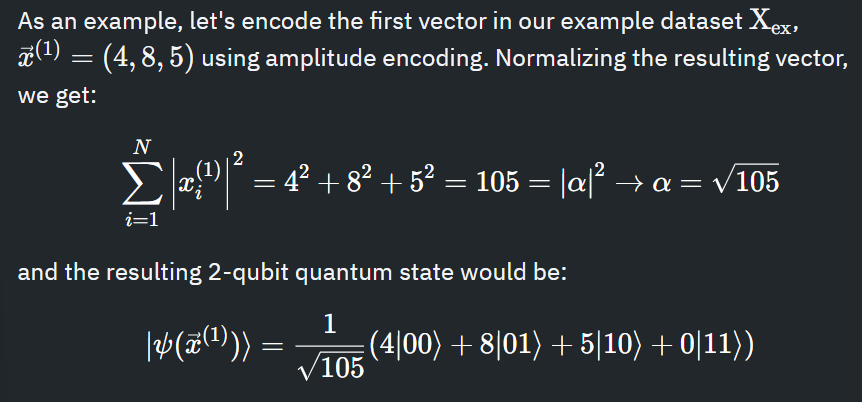

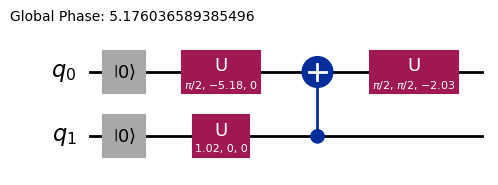

In [ ]:
desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0,
]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0, 1])

qc.decompose(reps=5).draw(output="mpl")

# Notes how 2^n >= N

Key advantage of amplitude encoding over basis encoding: given the fixed ordering of the basis states, this amplitude encoding preserves the order of the numbers encoded. It will often also be encoded more densely (fewer qubits potentially required). However, amplitude encoding is generally an inefficient procedure that requires arbitrary state preparation, which is exponential in the number of CNOT gates.

**Angle Encoding**

Angle encoding is of interest in many QML models using Pauli feature maps such as QSVMs and VQCs. Related to phase encoding and dense angle encoding.

Here we will use "angle encoding" to refer to a rotation in θ, or a rotation away from the z axis. 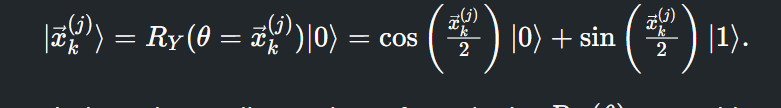

What is unique? Each feature value is mapped to a coressponding qubit, leaving the qubits in product state. One numerical value is encoded at a time, rather than a whole set of features from a data point. n qubits are required N data features. **The resulting circuit is a constant depth. **

In [1]:
from qiskit.quantum_info import Statevector
from math import pi

qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
states = state1, state2

ModuleNotFoundError: No module named 'qiskit'

In [2]:
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data


def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)

    bloch_plot.add_vectors(bloch_vecs)

    if len(states) > 1:

        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)

        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]

    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"

    if plot_trace_points:

        def trace_points(bloch_vec1, bloch_vec2):
            # bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2(
                [bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]]
            )
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]

        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])

    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]

    bloch_plot.render()


plot_Nstates(states, axis=None, plot_trace_points=True)

ModuleNotFoundError: No module named 'qiskit'

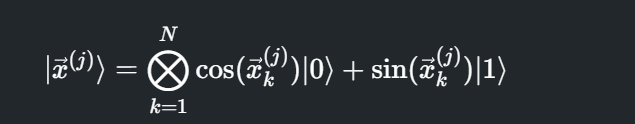

**Phase Encoding**
The phase angle of a qubit is a real-valued angle Φ about the z-axis from the +x axis.

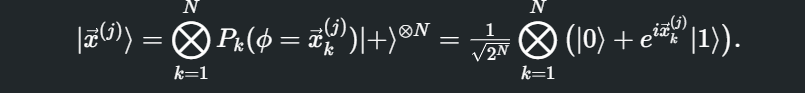

Circuit depth = 2, including the Hadamard layer, which makes it an efficient encoding scheme.

In [3]:
qc = QuantumCircuit(1)
qc.h(0)  # Hadamard gate rotates state down to Bloch equator
state1 = Statevector.from_instruction(qc)

qc.p(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)

states = state1, state2

qc.draw("mpl", scale=1)
plot_Nstates(states, axis=None, plot_trace_points=True)

NameError: name 'QuantumCircuit' is not defined

In [ ]:
# Example of implement phase encoding on phase_data
phase_data = [4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0]
qc = QuantumCircuit(len(phase_data))
for i in range(0, len(phase_data)):
    qc.h(i)
    # Computes the fraction of the rotation about the z axis
    qc.rz(phase_data[i] * 2 * math.pi / float(max(phase_data)), i)
qc.draw(output="mpl")

**Dense Angle Encoding**

DAE is a comination of angle encoding and phase encoding. Allows two feature values to be encoded in a single qubit - one angle with a Y-axis rotation and the other with a z-axis rotation angle.

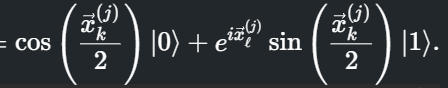

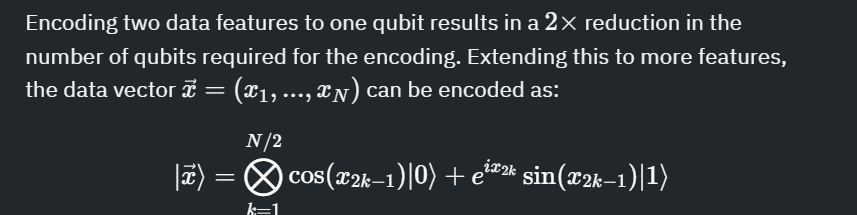

In [4]:
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(3 * pi / 8, 0)
state2 = Statevector.from_instruction(qc)
qc.rz(7 * pi / 4, 0)
state3 = Statevector.from_instruction(qc)
states = state1, state2, state3

plot_Nstates(states, axis=None, plot_trace_points=True)

NameError: name 'QuantumCircuit' is not defined

In [ ]:
# Implementation of Dense Angle Encoding
dense_data = [4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0, 3, 7, 5, 0]
qc = QuantumCircuit(int(len(dense_data) / 2))
entry = 0
for i in range(0, int(len(dense_data) / 2)):
    qc.ry(dense_data[entry] * 2 * math.pi / float(max(dense_data)), i)
    entry = entry + 1
    qc.rz(dense_data[entry] * 2 * math.pi / float(max(dense_data)), i)
    entry = entry + 1
qc.draw(output="mpl")

**Encoding with built-in feature maps**
Angle encoding, phase encoding, and dense encoding prepared product states with a feature encoded on each qubit (or two features per qubit). This is different from basis and amplitude encoding , in that those methods make use of entangled states.

Generally, methods that encode in product states yield shallower circuits and can store 1 or 2 features on each qubit.

**Many encoding schemes built into Qiskit allow encoding both before and after an entanglement layer, as opposed to just at the beginning.**



In [ ]:
# Can encode 8 features on only 2 qubits!
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=2, reps=1, insert_barriers=True)
circuit.decompose().draw(output="mpl")

Instead of increasing the number of qubits, you might choose to increase the number of repetitions of entangling and rotation layers.

**Z Feature Map (ZFM)**
It is a natural extension of phase encoding. Alternating layer of single-qubit gates: Hadamard gate layer and phase gate layers. The intial state is given below:


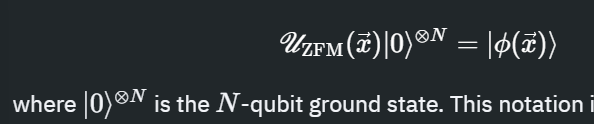

One-to-one mapping of feature --> qubits (8 features --> 8 qubits)
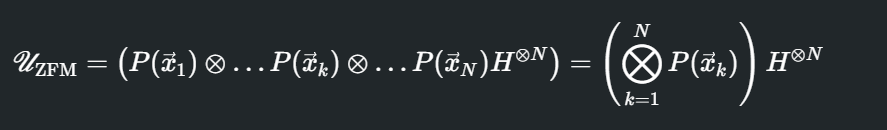

Phase gate has one feature as an argument.

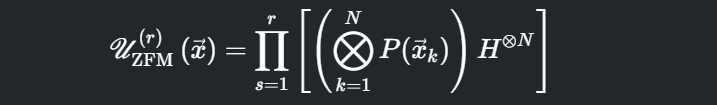

In [ ]:
qc0 = QuantumCircuit(1)
qc1 = QuantumCircuit(1)

qc0.h(0)
qc0.p(pi / 2, 0)

qc1.h(0)
qc1.p(pi / 3, 0)

# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)

qc.draw("mpl", scale=1)


from qiskit.circuit.library import z_feature_map

zfeature_map = z_feature_map(feature_dimension=2, reps=3)
zfeature_map = zfeature_map.assign_parameters([(1 / 2) * pi / 2, (1 / 2) * pi / 3])
zfeature_map.decompose().draw("mpl")


# NOTE: x_feature_map class parametes beta are multiplied by 2 before mappin to the phase gate.

**ZZ Feautrre Map**
Extends the ZFM with the inclusion of two-qubit entangling gate, specifically the ZZ-rotation gate R_xx(θ)


In [ ]:
qc = QuantumCircuit(2)
qc.rzz(pi, 0, 1)
qc.draw("mpl", scale=1)

# We encode a single feature of the data vecotr x: x_k = pi

#.decompose() to see all the constituent gate
qc.decompose().draw("mpl", scale=1)


from qiskit.circuit.library import zz_feature_map

feature_dim = 2
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose(reps=1).draw("mpl", scale=1)

In [ ]:
# Linear Entanglement
feature_dim = 4
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose().draw("mpl", scale=1)

**In the linear entanglement scheme, nearest-neighbor (numbered) pairs of qubits in this circuit are entangled.**

**Pauli Feature Maps**
The Pauli feature map (PFM) is the generalization of the ZFM and ZZFM to use arbitrary Pauli gates.


Generalized procedure of feature mapping below:


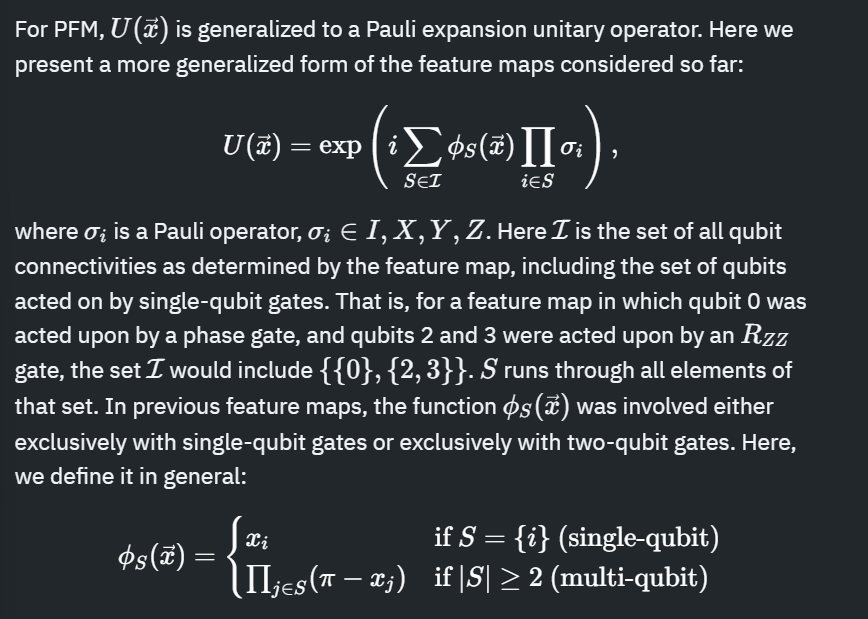

In [ ]:
from qiskit.circuit.library import pauli_feature_map

feature_dim = 3
pfmap = pauli_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1, paulis=["Y", "XX"]
)

pfmap.decompose().draw("mpl", scale=1.5)

In [ ]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

feature_dim = 2
fig, axs = plt.subplots(9, 2)
i_plot = 0
for paulis in [
    ["I"],
    ["X"],
    ["Y"],
    ["Z"],
    ["XX"],
    ["XY"],
    ["XZ"],
    ["YY"],
    ["YZ"],
    ["ZZ"],
    ["X", "ZZ"],
    ["Y", "ZZ"],
    ["Z", "ZZ"],
    ["X", "YZ"],
    ["Y", "YZ"],
    ["Z", "YZ"],
    ["YY", "ZZ"],
    ["XY", "ZZ"],
]:
    pfmap = pauli_feature_map(feature_dimension=feature_dim, paulis=paulis, reps=1)
    circuit_drawer(
        pfmap.decompose(),
        output="mpl",
        style={"backgroundcolor": "#EEEEEE"},
        ax=axs[int((i_plot - i_plot % 2) / 2), i_plot % 2],
    )
    axs[int((i_plot - i_plot % 2) / 2), i_plot % 2].title.set_text(paulis)
    i_plot += 1

fig.set_figheight(16)
fig.set_figwidth(16)

**Transpilation** is the process of converting the quantum circuit from a high-level abstraction to one that is ready to run on a real quantum computer, taking into account constraints of the hardware.

**Quantum Kernels**
The "Quantum kernel method" refers to any method that uses quantum computers to estimate a kernel. In this context, "kernel" will refer to the kernel matrix or its individual entries.


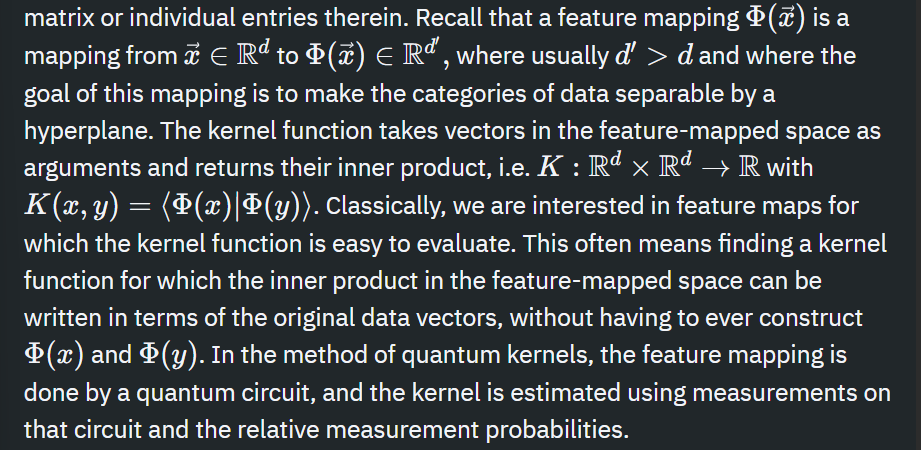

**Workflow Using Qiskit Patterns**

Step 1: Map classical inputs to a quantum problem.
Input: Training dataset
Output: Abstract circuit for calculating a kernel matrix entry.

We need to map our data into the Hilbert space of states of our quantum computer --> We do this by constructing a data-dependent circuit.

NOTE: To calculate a single kernel matrix element, we will want to encode two different points, so we can estimate their inner product.

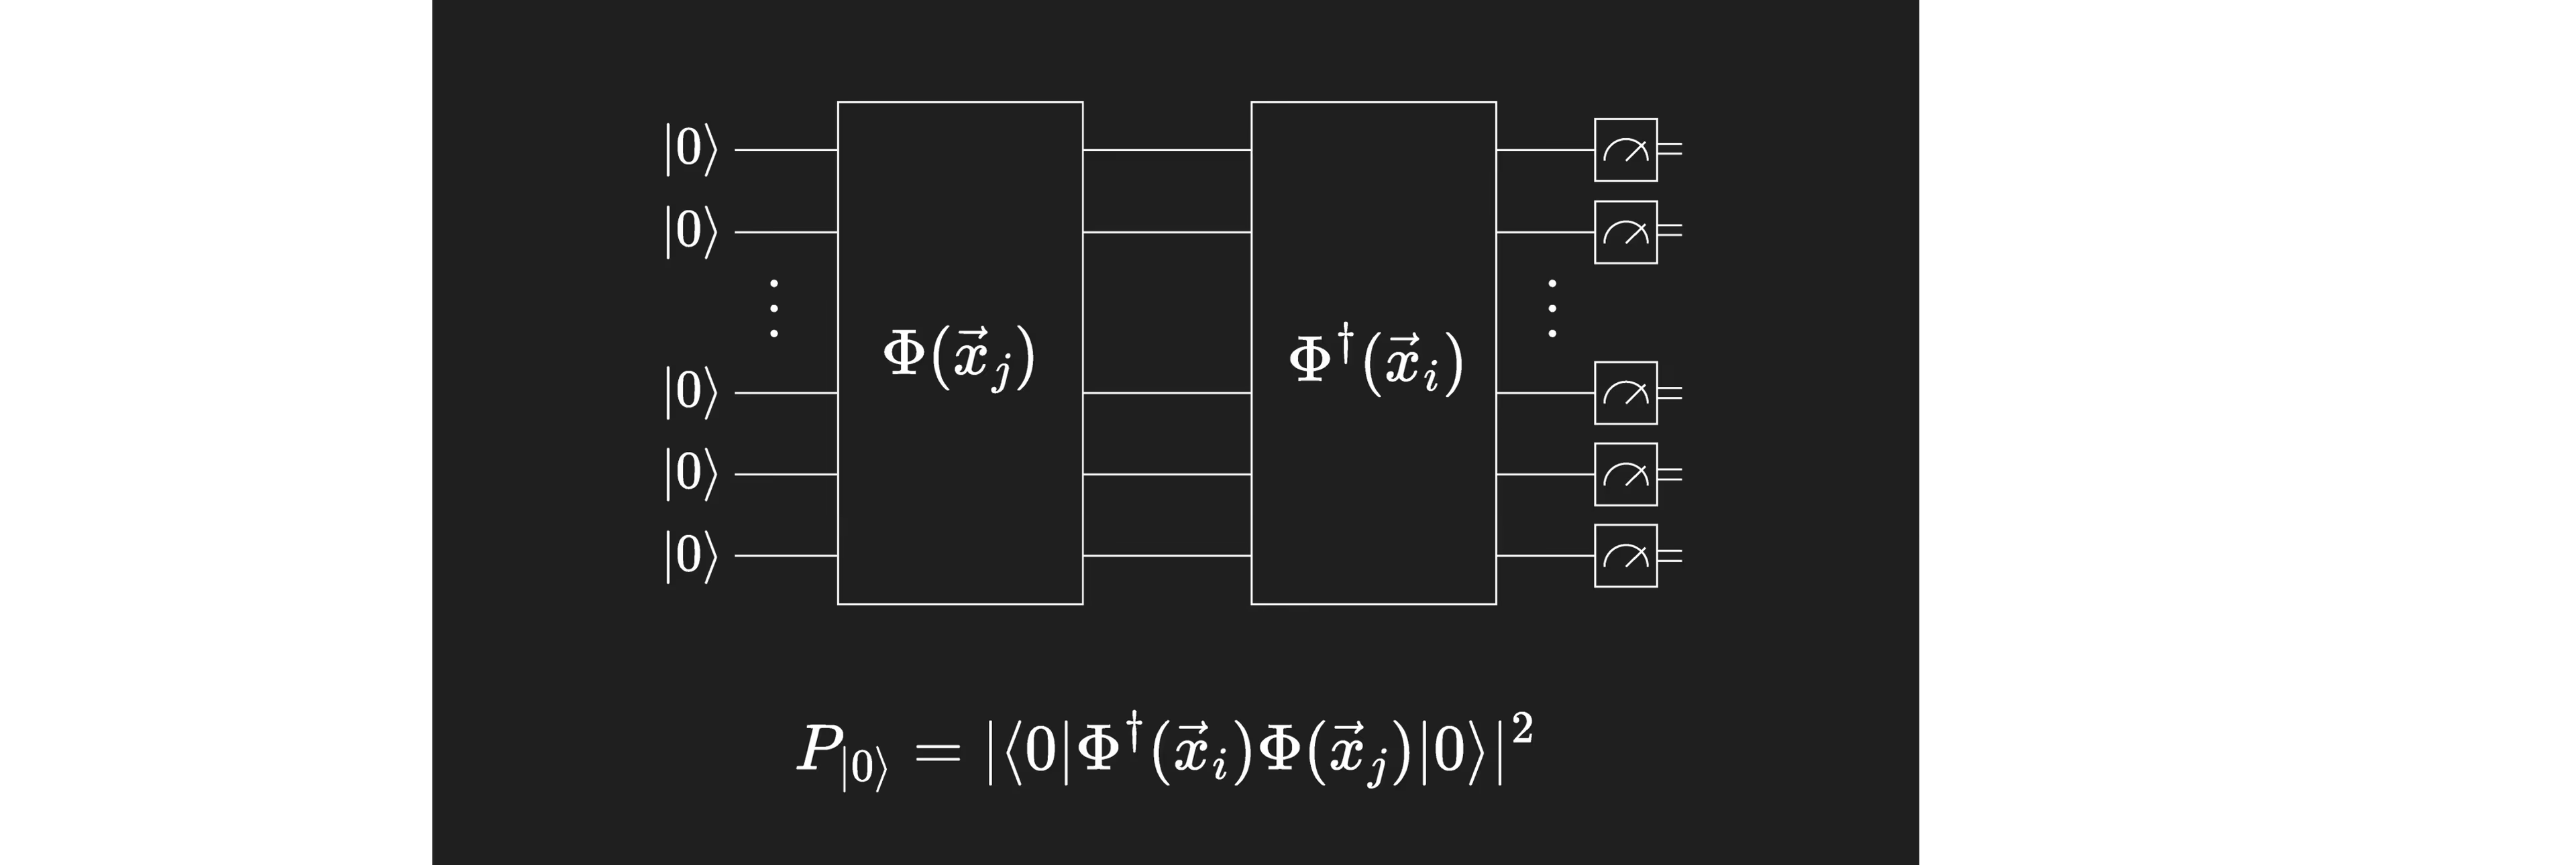



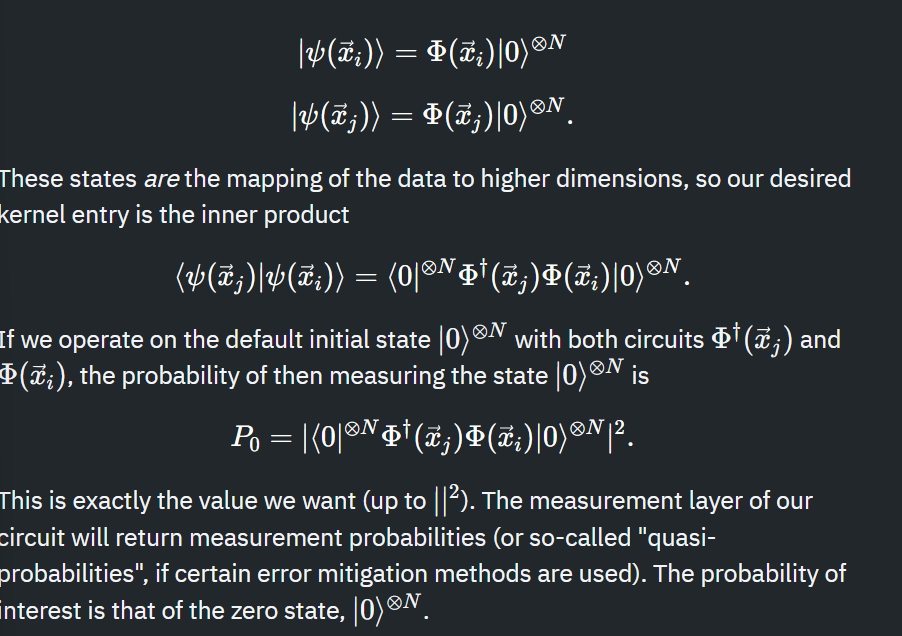

Step 2: Optimize problem for quantum execution
Input: Abtract circuit, not optimized for a particular backend.
Output: Target circuit and observable, optimized for the selected QPU.

* generate_preset_pass_manage function specifies an optimization routine for our circuit with respect to the real quantum computer.
* optimization_level=3 --> highest level of optimization

This includes considerations like selecting physical qubits to correspond to qubits in the abstract quantum circuit that will minimize gate depth, or selecting physical qubits with the lowest available error rates

Step 3: Execute Using Qiskit Runtime Primitives
Input: Target Circuit
Output: Probability distribution

Use the **Sampler** primitive from Qiskit Runtime to reconstruct a probability distribution of states yielded from sampling the circuit.

If/since the circuit is optimized we can skip_transpilation=True and passing the optimized circuit to the Sampler.

---

Step 4: Post-process, return results in classical format
Input: Probability distribution
Output: A single kernel matrix element, or a kernel matrix if repeating.

Once we have a kernel matrix, we can use it in many classical machine learning algorithms that accept pre-calculated kernels. For example: qml_svc = SVC(kernel="precomputed"). We can then use classical workstreams to apply our model on our testing data, and get an accuracy score.

In the following example we will apply the quantum kernel method to:
1. A single kernel matrix entry for data with relatively few features, using a real backend.
2. An entire data set with relatively few features, using a simulated backend, so that we can see how the quantum workstream connects with classical machine learning methods
3. A single kernel matrix entry for data with many features, using a real quantum computer.

In [ ]:
!pip install scikit-learn

Step 1: Classical inputs --> Quantum Problem

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Two mock data points, including category labels, as in training
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]

# Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]

In [12]:
# from qiskit.circuit.library import zz_feature_map
# fm = zz_feature_map(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)
from qiskit.circuit.library import z_feature_map

fm = z_feature_map(feature_dimension=np.shape(train_data)[1])

unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

In [ ]:
from qiskit.circuit.library import unitary_overlap


overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")

Step 2: Optimize problem for quantum execution

In [13]:
pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


In [ ]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

In [ ]:
# Apply level 3 optimization to our created overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)

Step 3: Execute Using Qiskit Runtime Primitive

In [ ]:
# Benchmarked on ibm_kyoto, 7-11-24, took 4 sec.

# Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

num_shots = 10000

# Use sampler and get the counts

sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

**What each of the functions does**

In [3]:
# Run this for a simulator
# from qiskit.primitives import StatevectorSampler

# from qiskit_ibm_runtime import Options, Session, Sampler

# num_shots = 10000

# Evaluate the problem using state vector-based primitives from Qiskit
# sampler = StatevectorSampler()
# results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
# counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
# counts = results[0].data.meas.get_int_counts()

Step 4: Post-process, return result in classical format

We can use plot_distribution --> pictures like the one below can quickly become intractable for a larger number of qubits.

In [ ]:
from qiskit.visualization import plot_distribution

plot_distribution(counts_bit)

In [ ]:
# But, let's say we want a clearer view that only examines the top 10 most probable measurements
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()

visualize_counts(counts, overlap_circ.num_qubits)

Very deep circuits will introduce high error rates. When that error rate is compounded over many qubits, this will reduce the probability of measuring the zero state, substantially.

**Full Kernel Matrix Example**

We extend the procedure above for the binary classification of a full dataset.
This dataset consists of 128 rows (data points) and 14 features on each point. There is a 15th element that indicates the binary category of each point (±1)

---

In [4]:
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)

# Prepare training data
train_size = 90
X_train = df.values[0:train_size, :-1]
train_labels = df.values[0:train_size, -1]

# Prepare testing data
test_size = 30
X_test = df.values[train_size : train_size + test_size, :-1]
test_labels = df.values[train_size : train_size + test_size, -1]

--2025-07-09 13:42:34--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49405 (48K) [text/plain]
Saving to: ‘dataset_graph7.csv’

dataset_graph7.csv  100%[===================>]  48.25K  --.-KB/s    in 0.009s  

2025-07-09 13:42:34 (5.35 MB/s) - ‘dataset_graph7.csv’ saved [49405/49405]



In [ ]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

**Whenever you know something about your data structure that may inform what feature map structure would be most useful, it is advisable to create your own custom feature map that leverages that knowledge.**

In [ ]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)

# To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

Two nested for loops to calculate the inner products--> leverage symmetry to reduce the number of calculations by 1/2
Set the diagonal elements to 1, as they should be in the absence of noise.

Once the kernel matrix has been fully populated, we repeat the process for the test data and populate the test_matrix. This is really also a kernel matrix; we simply give it a different name to distinguish the two.

In [ ]:
# To use a simulator
from qiskit.primitives import StatevectorSampler

# Remember to insert your token in the QiskitRuntimeService constructor to use real quantum computers
# service = QiskitRuntimeService()
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )

num_shots = 10000

# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()

for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()

        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )

        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1

print("training done")

# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()

        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )

        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots

print("test matrix done")

In [5]:
# Step 4: Return result in a classical format
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC

# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

In [5]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)

# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

**Quantum Variational Circuits & Quantum Neural Networks**

VQCs are used for data classification tasks. At one point it was common to refer to a subset of VQCs as QNNs in analogy with classical neural networks.
Convolutional layers are borrowed, but are different in many ways. For example, in a parameterized quantum circuits not all the data need to be loaded in the first (input) layer; we can load some data in the first layer, apply some gates and then load additional data("reuploading"). We can think of QNNS as a subset of parametrized quantum circuits.

Dataset: Exceptionally easy to classify, consisting of horizontal stripes or vertical stripes. --> Not reasonable to expect a quantum speed-up for such simple cases where classical algorithms are so efficient.


Steps:
1. Load data from an image into a quanutm circuit.
2. Construct an ansatz for a VQC (or QNN), and adjust it --> to fit your problem
3. Train you models and use it to make accurate predictions.
4. Scale the problem, and recognize limits of current quantum computers.


Data Generation
The code below defines a data set of images with set pixel dimensions. One full row or column of the image is assigned the value π/2, and the remaining pixels are assigned random values on the interval (0,π/4).

In [1]:
# Data Generation Code

# This code defines the images to be classified:
import numpy as np

# Total number of "pixels"/qubits
size = 8
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2

def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))

    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1

    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.

    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1

    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))

        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels


hor_size = round(size / vert_size)

In [2]:
# Split using sklearn for training and testing
from sklearn.model_selection import train_test_split

np.random.seed(42)
images, labels = generate_dataset(200)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

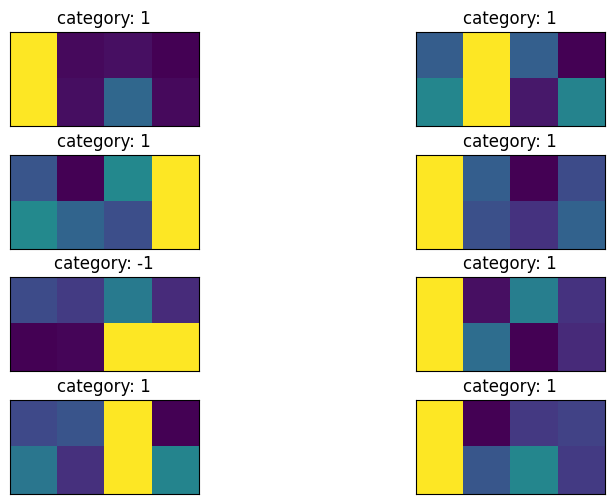

In [3]:
import matplotlib.pyplot as plt

# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = "category: " + str(train_labels[i])
    titles.append(title)

# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})

for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [4]:
print(train_labels[:8])

[1, 1, 1, 1, -1, 1, 1, 1]


The goal is to find a function f with parameters theta that maps a data vector / image x to the correct category: f(x) --> +- 1.

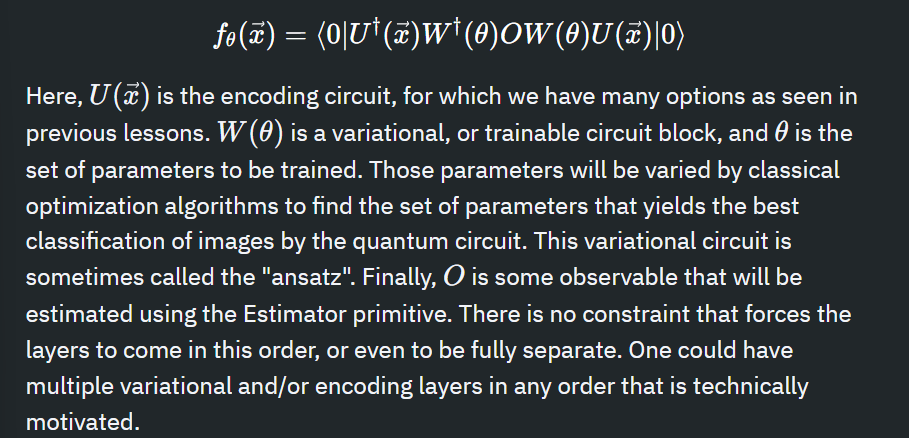

For encoding our data, we will use the z_feature_map, as it keeps the circuit depth low compared to some other feature mappings.

In [ ]:
from qiskit.circuit.library import z_feature_map

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")

Next step is to determine on an ansatz to be trained. Here are a FEW possible/ introductory conditions:

1. Hardware: All modern quantum computers are more prone to errors and more susceptible to noise than their classical counterparts. Using an ansatz that is excessively deep (especially in transpiled, two-qubit depth) will not produce good results.Entangling adjacent qubits does not increase the depth by too much, but entangling very distant qubits can increase depth substantially, as we must insert swap gates to move information onto qubits that are adjacent in order for them to be entangled. --> Similar to how "virtual pages" work in an Operating System.

2. The Problem: For example, what attributes of an ansatz would correspond to this correlation between adjacent pixels?
Simply noted, including entanglement and CNOT gates between qubits corresponding to adjacent pixels seems like a good idea.

3. Number of Parameters: Each independently parametrized quantum gate in the circuit increases the space to be classically optimized, and results in slower convergence. But as problems scale up, one may encounter barren plateaus --> This is the phenomenon where the optimization landscape of a variational quantm algorithms becomes exponentially flat and featureless as the problem size increases --> This causes vanishing gradients, making it difficult to effeciently train the algorithm. It should be noted that the increasing number of parameters is not the only consideration in avoiding **barren plateaus**; other considerations include global cost functions and random parameter initialization. --> Ultimately we are trying to minimize this cost function.


In [ ]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)

# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)

# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)

# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])

# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)

# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

# Draw the circuit
qnn_circuit.draw("mpl")

Analogy of out ansatz to neural networks:
We can think of U(x) the encoding being most similar to the layer that loads input values from the image.
And, W(theta) beying like the layer of variable "weights."

In [ ]:
# QNN ansatz
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

We must now define an observable, so we can use it in our cost function.

We will obtain an expectation value for this observable using Estimator.

One can add layers to combine information onto fewer qubits (called a convolutional layer), such that measurements are only needed on a subset of the qubits in the circuit (as in convolutional neural networks). Or one can measure some attribute from each qubit.

We take the latter apporach, so we add a Z operator for each qubit. Why Z?
1. Binary classification task, and measurement of Z can yield two possible outcomes.
2. Eigenvalue (+-1) are well separated, so 0 can simply be used as a cutoff value.
3. It is straightforward to measure in Pauli Z basis with no extra gate overhead.

In [ ]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

Run a forward pass.

NOTE: The function below takes in the input_params and weight_params separately (static parameters vs a set of variable paramters to be optimized):


In [ ]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.

    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

Loss Function

We need a loss function to calculate the diffference between the predicted and calculated values of the labels.
We choose MSE for this loss function.



In [ ]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

Defined slightly different loss function that is a function of the variable parameters (weights), for use by the classical optimizer.



In [ ]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

Above we referred to using a classical optimizer. When we get to searching through weights to minimize the cost function, we will use the optimizer COBYLA:

In [ ]:
from scipy.optimize import minimize


# We need to set some initial global variables for the cost function
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

Step 2: Optimize problem for quantum execution

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

We optimized the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling.

In [ ]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

We use the pass manager on the circuit. The layout changes that results must be applied to the observable as well. For very large circuits, the heuristics used in circuit optimization may not always yield the best and shallowest circuit. In this case --> run such pass managers several times and use the best circuit.

In [ ]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

Step 3: Execute Using Qiskit Primitives

Loop over the dataset in batches and epochs. We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.


In [ ]:
from qiskit.primitives import StatevectorEstimator as Estimator

batch_size = 140
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Step 4: Post-process, return result in classical format

Testing and Accuracy


In [ ]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

In [ ]:
# Previous model's accuracy was only 60%, we need to verify this is the case

pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

Now we need to examine why the model is not classifying these data well.
1. Did we stop training too soon?
2. Did we construct a bas ansatz?
3. Did we construct an ansatz with too many parameters to be trainable?  

In [ ]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

Let's take a closer look at the images that were not classified correctly, and see if we can understand what is happening.

In [ ]:
missed = []
for i in range(len(test_labels)):
    if pred_test_labels[i] != test_labels[i]:
        missed.append(test_images[i])
print(len(missed))

In [ ]:
fig, ax = plt.subplots(12, 2, figsize=(6, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(len(missed)):
    ax[i // 2, i % 2].imshow(
        missed[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.02, hspace=0.025)

We observe that the vast majority of the wrongly-classified images have a vertical line.

Now we need to go back and revist/trace oursteps.

Step 1 Revisited:
In mapping our problem to a quantum circuit, we should have explicitly thought about the how the information in adjacent pixels determines class. Since the classification is binary, one could imagine simply saying that if such a horizontal line is not detected, then it is a vertical line.

Our previous variational circuit contained CNOT gates between qubits (and therefore pixels) 0 & 1, 1 & 2, and 2 & 3. That covers any horizontal lines across the top of the image, but it does not directly detect vertical lines, nor does it completely detect horizontal lines, as it ignores the lower row.

. To fully detect all horizontal lines, we would want to have a similar set of CNOT gates between qubits (pixels) 4 & 5, 5 & 6, and 6 & 7

Our goal now: Check whether it is sufficient to detect that there IS or IS NOT a horiztonal line.



In [ ]:
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)

# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)

# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)

# Here is an extended list of qubit pairs between which we want CNOT gates. This now covers all pixels connected by horizontal lines.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3], [4, 5], [5, 6], [6, 7]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])

# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)

# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

# Combine the feature map and variational circuit
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [ ]:
#Step 3 Revisited
from qiskit.primitives import StatevectorEstimator as Estimator

batch_size = 140
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

In [ ]:
obj_func_vals_revised = objective_func_vals
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_revised, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

In [ ]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

# Further mapping provided 100% accuracy!

Scaling and Running on Real Quantum Computers

Data
We can increase the size of our images. We can simulate upto 32 uits using non-Clifford gates.

In [ ]:
# This code defines the images to be classified:

import numpy as np

# Total number of "pixels"/qubits
size = 36
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 6
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 6


def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))

    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1

    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.

    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1

    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
            # Randomly select one of the several rows you made above.
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select one of the several rows you made above.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels


hor_size = round(size / vert_size)

Quantum computing time is a precious resource, we will use a very small training set, and very few optimization steps. This demonstrates our previously shown/standard workflow.

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
# Here we specify a very small data set. Increase for realism, but monitor use of quantum computing time.
images, labels = generate_dataset(10)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

In [ ]:
import matplotlib.pyplot as plt

# Generate a figure with nested images using subplots.

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

Step 1: Map the problem to a quantum circuit

In [ ]:
import matplotlib.pyplot as plt

# Generate a figure with nested images using subplots.

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [ ]:
# This creates a circuit with the cxs in the compressed order.

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

qnn_circuit = QuantumCircuit(size)
params = ParameterVector("θ", length=2 * size)
for i in range(size):
    qnn_circuit.ry(params[i], i)

# CNOT gates between horizontally adjacent qubits.
for i in range(vert_size):
    for j in range(hor_size):
        if j < hor_size - 1:
            qnn_circuit.cx((i * hor_size) + j, (i * hor_size) + j + 1)

# CNOT gates between vertically adjacent qubits, likely not necessary based on our preliminary simulation.
#        if i<vert_size-1:
#            qnn_circuit.cx((i*hor_size)+j,(i*hor_size)+j+hor_size)
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
qnn_circuit_large = qnn_circuit

print(qnn_circuit_large.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit_large.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
# qnn_circuit_large.draw()

In [ ]:
# Combine the feature map and variational circuit
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Check the depth of the full circuit
print(full_circuit.decompose().depth())
print(
    f"2+ qubit depth: {full_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)


# qnn_circuit is our model or "ansatz" and we implemented a Z-feature map

In [ ]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

Step 2: Optimize problem for quanutm execution

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# To run on hardware, select the least busy quantum computer or specify a particular one.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
# backend = service.backend("ibm_kyoto")

print(backend.name)

In [ ]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

We apply the pass manager several times.
NOTE: For very wide or very deep circuits, there can be large variability in the transpiled two qubit depths. For such circuits heuristics can return various transpilations on large circuits --> we want the best (shallowest) result.

In [ ]:
circuit_ibm = transpiled_qcs[2]
observable_ibm = observable.apply_layout(circuit_ibm.layout)
print(circuit_ibm.decompose().depth())
print(
    f"2+ qubit depth: {circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

step 3: Execute Qiskit Primitives

In [ ]:
# This was run on ibm_nazca on 10-4-24, and took 7 min.

from qiskit_ibm_runtime import (
    EstimatorV2 as Estimator,
    Session,
)

batch_size = 7
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit_ibm
observable = observable_ibm
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
# weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
# Or re-load weights from a previous calculation
weight_params = np.array(
    [
        3.35330497,
        5.97351416,
        4.59925358,
        3.76148219,
        0.98029403,
        0.98014248,
        0.3649501,
        6.44234523,
        3.77691701,
        4.44895122,
        0.12933619,
        6.09412333,
        5.23039137,
        1.33416598,
        1.14243996,
        1.15236452,
        1.91161039,
        3.2971419,
        3.71399059,
        1.82984665,
        3.84438512,
        0.87646578,
        1.83559896,
        2.30191935,
        2.86557222,
        4.93340606,
        1.25458737,
        3.23103027,
        3.72225051,
        0.29185655,
        3.81731689,
        1.07143467,
        0.40873121,
        5.96202367,
        6.067245,
        5.07931034,
        1.91394476,
        0.61369199,
        4.2991629,
        2.76555968,
        0.76678884,
        3.11128829,
        0.21606945,
        5.71342859,
        1.62596258,
        4.16275028,
        1.95853845,
        3.26768375,
        3.43508199,
        1.1614748,
        6.09207989,
        4.87030317,
        5.90304595,
        5.62236606,
        3.75671636,
        5.79230665,
        0.55601479,
        1.23139664,
        0.28417144,
        2.04411075,
        2.44213144,
        1.70493625,
        5.20711134,
        2.24154726,
        1.76516358,
        3.40986006,
        0.88545302,
        5.04035228,
        0.46841551,
        6.2007935,
        4.85215699,
        1.24856745,
    ]
)

with Session(backend=backend):
    estimator = Estimator(
        mode=Session(service, backend=backend), options={"resilience_level": 1}
    )

    for epoch in range(num_epochs):
        for i in range((num_samples - 1) // batch_size + 1):
            print(f"Epoch: {epoch}, batch: {i}")
            start_i = i * batch_size
            end_i = start_i + batch_size
            train_images_batch = np.array(train_images[start_i:end_i])
            train_labels_batch = np.array(train_labels[start_i:end_i])
            input_params = train_images_batch
            target = train_labels_batch
            iter = 0
            # We can increase maxiter to do a full optimization.
            res = minimize(
                mse_loss_weights,
                weight_params,
                method="COBYLA",
                options={"maxiter": 20},
            )
            weight_params = res["x"]

Step 4: Post-processing to monitor convergence of the classical optimization

In [ ]:
obj_func_vals_qc = objective_func_vals
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_qc, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()